# 1.1 Load libraries

Note: After resolving conflicts, runs the entire notebook to make sure none of the old code is broken.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os
from scipy.stats import norm, binom

from pypfopt import EfficientFrontier, risk_models, expected_returns, objective_functions, base_optimizer, black_litterman, discrete_allocation

# 1.2 Load the stocks into memory and perform some preprocessing steps

The data is stored as key-value pairs in a dictionary, with the ticker referencing the respective dataframe. Following that, the date is changed into a datetime object and a new column for log-returns is added.

In [2]:
# load stocks into a dictionary
stocks = {}
do_not_append = ['FSELX','IPHI', '005930'] # FSELX is our fund, while IPHI does not have data and has been bought over by MRVL. 005930 non-USD.  'ASX', 'NXPI', 'TSM' companies are not based in the US but traded in US markets
for file_name in os.listdir('best_data/'):
  ticker = file_name.split(".")[0]
  if ticker in do_not_append:
    pass
  else:
    stocks[f'{ticker}'] = pd.read_csv(f'best_data/{file_name}') # for each stock, add its ticker as the key and dataframe as the value

In [3]:
print(list(stocks.keys())) # print the stock tickers for easy referencing

['ADI', 'AEIS', 'AMAT', 'AMBA', 'AMD', 'AOSL', 'ASX', 'AVGO', 'CRUS', 'DIOD', 'ENPH', 'FLEX', 'IIVI', 'INTC', 'JBL', 'LRCX', 'MCHP', 'MRVL', 'MTSI', 'MU', 'MXL', 'NVDA', 'NXPI', 'OLED', 'ON', 'QCOM', 'SEDG', 'SGH', 'SMTC', 'SYNA', 'TSM', 'TTMI', 'TXN', 'XLNX']


In [4]:
# Change date column into a datetime object
# Add a new column for log returns
for ticker, df in stocks.items():
  df['Date'] = df['Date'].apply(pd.to_datetime)
  df['LogReturns'] = np.append(np.nan,np.diff(np.log(df['Adj Close']))) # Fill dataframe with the log returns. The first value will be nan because there is no log returns for it.

In [5]:
# preview a stock
stocks['TXN'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2016-10-04,69.660004,69.910004,69.099998,69.589996,61.006310,4089500,NaN
1,2016-10-05,69.849998,70.839996,69.010002,70.599998,61.891724,4789600,0.014409
2,2016-10-06,70.440002,71.000000,70.029999,70.959999,62.207321,4061500,0.005086
3,2016-10-07,71.000000,71.059998,70.449997,70.870003,62.128426,3673600,-0.001269
4,2016-10-10,71.080002,71.330002,69.900002,69.930000,61.304375,4893200,-0.013352


In [6]:
top_30 = ['SYNA', 'MRVL', 'SGH', 'ENPH', 'JBL', 'CRUS', 'MCHP', 'AEIS', 'MTSI', 'AMAT', 'NVDA', 'ON', 'TTMI', 'SMTC', 'AVGO', 'XLNX', 'TSM', 'IIVI', 'QCOM', 'NXPI', 'FLEX', 'DIOD', 'AMD', 'MXL', 'ADI', 'INTC', 'TXN', 'LRCX', 'MU', 'OLED']
stocks_30 = {stock:df for stock,df in stocks.items() if stock in top_30}

# 1.3 Aggregate the returns into one dataframe

In [7]:
log_returns = pd.DataFrame(data=np.full((stocks['TXN'].shape[0],30),np.nan), columns = sorted(list(stocks_30.keys())), index = stocks_30['TXN'].Date) # create empty dataframe filled with NaNs, with index = Date and columns = stocks

# copy the log returns over from the stocks dictionary
for ticker, df in stocks_30.items():
  log_returns[ticker] = log_returns.index.map(stocks_30[ticker].set_index('Date')['LogReturns'])

# if simple returns are needed
simple_returns = np.exp(log_returns)-1
#simple_returns['RF'] = np.repeat(0.01/252,simple_returns.shape[0])

In [8]:
# preview log_returns
simple_returns.head()

,ADI,AEIS,AMAT,AMD,AVGO,CRUS,DIOD,ENPH,FLEX,IIVI,...,OLED,ON,QCOM,SGH,SMTC,SYNA,TSM,TTMI,TXN,XLNX
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-10-05,0.006849,0.008323,0.011145,-0.027260,0.026205,0.018109,0.024402,-0.008333,0.030837,0.043100,...,-0.006262,0.018062,0.002399,NaN,0.008727,0.049058,0.004607,0.019164,0.014513,0.006596
2016-10-06,0.000928,0.027513,-0.001670,0.026549,0.004093,0.012919,0.003270,0.016807,0.004986,0.026619,...,0.003819,0.002419,0.010473,NaN,-0.002884,0.054531,0.007861,0.001709,0.005099,0.000375
2016-10-07,-0.004943,-0.015448,-0.004684,-0.030172,0.000115,-0.000739,-0.016760,-0.041322,-0.000709,-0.005418,...,-0.000761,-0.012068,0.009624,NaN,-0.004700,0.017339,0.013325,0.014505,-0.001268,-0.010107
2016-10-10,-0.016610,0.004184,-0.012437,0.013333,0.003214,0.023122,-0.007102,-0.086207,-0.004965,0.003891,...,0.013707,-0.012215,-0.013785,NaN,-0.027243,0.014630,0.003207,0.000000,-0.013264,-0.012857


The stock SGH has a lot of NaN values. We take a closer look at it.

In [9]:
# preview SGH
stocks['SGH'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2017-05-24,12.00,14.000,11.50,13.45,13.45,1415200,NaN
1,2017-05-25,13.85,14.320,13.35,13.50,13.50,237900,0.003711
2,2017-05-26,13.36,13.624,12.46,13.23,13.23,56200,-0.020203
3,2017-05-30,13.20,13.255,12.28,12.98,12.98,71200,-0.019077
4,2017-05-31,13.02,13.500,12.93,13.10,13.10,55700,0.009203


SGH only begins at a later date, explaining the NaNs we see in our earlier preview.}

# 1.4 Descriptive analytics of returns

c:\users\joobi\appdata\local\programs\python\python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


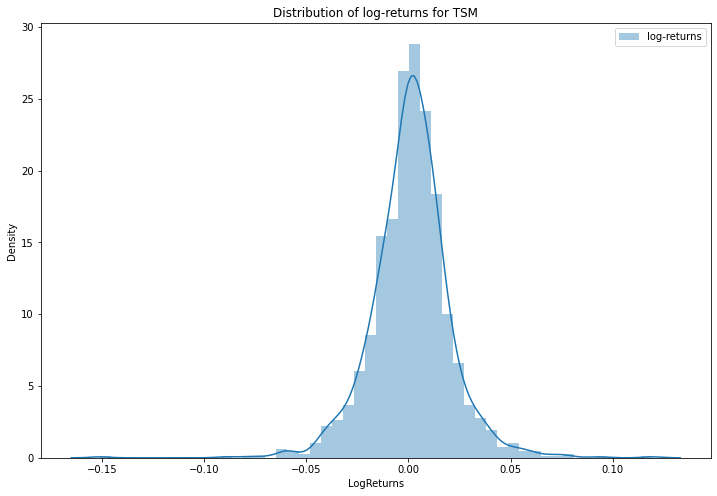

In [10]:
plt.figure(figsize=(12,8))
sns.distplot(stocks['TSM']['LogReturns'], kde=True, label='log-returns')
plt.legend()
plt.title("Distribution of log-returns for TSM")
plt.show()

In [11]:
returns_kurtosis = stocks['TSM']['LogReturns'].kurtosis()
returns_skew = stocks['TSM']['LogReturns'].skew()
print(f"Kurtosis: {returns_kurtosis}")
print(f"Skew: {returns_skew}")

Kurtosis: 5.739522840966442
Skew: -0.20199323738019406


# 2.1 Optimization

In [12]:
original_portfolio = pd.read_csv('original_weights_best.csv')
#original_portfolio['Security\'s Percentage of the Total Net Assets'] = np.round(original_portfolio['Security\'s Percentage of the Total Net Assets'],3)/100
original_portfolio.index = original_portfolio['Ticker Symbol Given by the Exchange']
del original_portfolio['Ticker Symbol Given by the Exchange']
original_portfolio = original_portfolio.loc[top_30,]

In [13]:
# normalize top 30 weights
original_portfolio['Security\'s Percentage of the Total Net Assets'] = (original_portfolio['Security\'s Percentage of the Total Net Assets']/original_portfolio['Security\'s Percentage of the Total Net Assets'].sum())

In [14]:
# drop nans
simple_returns = simple_returns.dropna()

# get in-sample time window to perform optimization on (inclusive)
is_start_date = '2019-6-30'
is_end_date = '2020-6-30'

# get out-of-sample time window for evaluation (inclusive)
oos_start_date = '2020-7-1'
oos_end_date = '2020-12-31'

in_sample_window = simple_returns[(simple_returns.index>=is_start_date)&(simple_returns.index<=is_end_date)].copy()
out_sample_window = simple_returns[(simple_returns.index>=oos_start_date)&(simple_returns.index<=oos_end_date)].copy()

In [15]:
# create dataframe to store results
pd.DataFrame(np.zeros(len(in_sample_window.columns)+1),index = np.append(in_sample_window.columns.values,'RF'))

comparison_table = pd.DataFrame(original_portfolio['Security\'s Percentage of the Total Net Assets'])
comparison_table = comparison_table.rename(columns={'Security\'s Percentage of the Total Net Assets':'original weights'})
comparison_table.loc['RF','original weights'] = 0

In [16]:
# Calculate expected returns and sample covariance using PyPortfolioOpt’s built-in methods
mu = expected_returns.mean_historical_return(in_sample_window, returns_data=True)
mu['RF'] = 0.01 # add risk-free assets
S = risk_models.sample_cov(in_sample_window, returns_data=True)
S.loc['RF',:] = 0 # add risk-free assets
S.loc[:,'RF'] = 0

oos_mu = expected_returns.mean_historical_return(out_sample_window, returns_data=True)
oos_mu.loc['RF'] = 0.01 # add risk-free assets
oos_S = risk_models.sample_cov(out_sample_window, returns_data=True)
oos_S.loc['RF',:] = 0 # add risk-free assets
oos_S.loc[:,'RF'] = 0

#print('Expected Returns:')
#print(mu)
#print('\n')
#print('Covariance Matrix:')
#print(S)
solver = "ECOS"

## Approach 1 -- Simple implementation
* Simple sub-sectors, semiconductors and others
* Base-line

In [17]:
# Set each stock to a sub-sector 
# Until someone has a better idea, use:
semiconductors = ['ADI','AMAT','AMD','AVGO','CRUS',
                  'DIOD','INTC','LRCX','MCHP','MRVL',
                  'MTSI','MU','MXL','NVDA','NXPI',
                  'OLED','ON','QCOM','SGH','SMTC',
                  'SYNA','TSM','TXN','XLNX']
others = ['AEIS','ENPH','FLEX','JBL','TTMI', 
               'IIVI','RF'] # AEIS and IIVI are also in the semiconductor subsector, but just putting them here first since they're in both areas. Every stock here except for IIVI are in the electrical/electronics scene. RF = risk-free

**Calculating risk aversion**

$U=E(R)-k*std(R)^2$

Assuming a portfolio consisting only of the market portfolio + risk-free assets, and expressing $E(R)$ and $std(R)$ in terms of their weights, $w$, we have:

$U=0.1*w+0.01*(1-w) - k*(w*0.18)^2$

where $w$ is the weight allocated to the market portfolio. Then,

$dU/dw = -0.0648*w*k+0.099$

If we choose w = 1, and then solving for $dU/dw = 0$, we get $k=1.528$

In [18]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper[stock] = 'semiconductors'
for stock in others:
  sector_mapper[stock] = 'others'

sector_lower = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper={}) # add sector constraint

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
print(ef.portfolio_performance(verbose=True, risk_free_rate=0.01))
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 125.6%
Annual volatility: 53.6%
Sharpe Ratio: 2.32
(1.2555892515033282, 0.5360763269173905, 2.3235296709814866)
ADI     0.00
AEIS    0.00
AMAT    0.00
AMD     0.00
AVGO    0.00
CRUS    0.00
DIOD    0.00
ENPH    0.25
FLEX    0.00
IIVI    0.00
INTC    0.00
JBL     0.00
LRCX    0.00
MCHP    0.00
MRVL    0.00
MTSI    0.25
MU      0.00
MXL     0.00
NVDA    0.25
NXPI    0.00
OLED    0.00
ON      0.00
QCOM    0.00
SGH     0.00
SMTC    0.00
SYNA    0.20
TSM     0.00
TTMI    0.00
TXN     0.00
XLNX    0.00
RF      0.05
dtype: float64
Expected annual return: 392.3%
Annual volatility: 37.8%
Sharpe Ratio: 10.35


In [19]:
comparison_table['1'] = np.round(results,2)

## Approach 2 -- Addressing the 0 weights problem the mean-variance optimization function causes
* Simple sub-sectors, semiconductors and others
* L2 regularization with gamma = 5

**From the pyportfolio webpage**

*In order to coerce the mean-variance optimizer to produce more non-negligible weights, we add what can be thought of as a “small weights penalty” to all of the objective functions, parameterised by γ (gamma).*

It is refered to as L2 regularisation despite having a different purpose from its usual use, to keep weights small. Here, is it used to keep weights bigger.

Note: Check different gamma values and portfolio's overall performance.

https://pyportfolioopt.readthedocs.io/en/latest/MeanVariance.html#pypfopt.objective_functions.L2_reg

In [20]:
# Set each stock to a sub-sector 
# Until someone has a better idea, use:
semiconductors = ['ADI','AMAT','AMD','AVGO','CRUS',
                  'DIOD','INTC','LRCX','MCHP','MRVL',
                  'MTSI','MU','MXL','NVDA','NXPI',
                  'OLED','ON','QCOM','SGH','SMTC',
                  'SYNA','TSM','TXN','XLNX']
others = ['AEIS','ENPH','FLEX','JBL','TTMI', 
               'IIVI','RF'] # AEIS and IIVI are also in the semiconductor subsector, but just putting them here first since they're in both areas. Every stock here except for IIVI are in the electrical/electronics scene. RF = risk-free

In [21]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in semiconductors:
  sector_mapper[stock] = 'semiconductors'
for stock in others:
  sector_mapper[stock] = 'others'

sector_lower = {'others': 0.3} # at least 30% to others

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper={}) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
print(ef.portfolio_performance(verbose=True, risk_free_rate=0.01))
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 79.8%
Annual volatility: 45.4%
Sharpe Ratio: 1.74
(0.7982307492835339, 0.45427751747745115, 1.7351304411023578)
ADI     0.0021
AEIS    0.0155
AMAT    0.0166
AMD     0.0648
AVGO    0.0066
CRUS    0.0255
DIOD    0.0328
ENPH    0.1256
FLEX    0.0080
IIVI    0.0394
INTC    0.0246
JBL     0.0111
LRCX    0.0509
MCHP    0.0027
MRVL    0.0415
MTSI    0.1082
MU      0.0163
MXL     0.0000
NVDA    0.1170
NXPI    0.0025
OLED    0.0000
ON      0.0000
QCOM    0.0202
SGH     0.0000
SMTC    0.0000
SYNA    0.0966
TSM     0.0572
TTMI    0.0289
TXN     0.0140
XLNX    0.0000
RF      0.0715
dtype: float64
Expected annual return: 255.3%
Annual volatility: 29.7%
Sharpe Ratio: 8.57


In [22]:
comparison_table['2'] = np.round(results,2)

## Approach 3 -- Addressing small number of sub-sectors issue
- Sub-sectors by market cap, with floor = 20%, and ceiling = 50%
- using L2 regularization with gamma = 5

***Additionally, we can consider putting a stock of a company into multiple sub-sectors, if the company produces goods of a different sub-sector as well. This has yet to be implemented, though I might get to it if I have time.
If someone wants to pick up the mantle and do the research, please go ahead.***

In [23]:
# market cap by three categories, 100B+, 10B+, and 1B+
cat_1 = ["TSM", "NVDA", "INTC", "AVGO", "TXN", "QCOM", "AMD", "AMAT"] # 100B+ market cap
cat_2 = ["ADI", "MU", "LRCX", "MRVL", "NXPI", "MCHP", "XLNX", "ENPH", "ON"] # 10B+ market cap
cat_3 = ["JBL", "FLEX", "OLED", "SYNA", "IIVI", "SMTC", "CRUS", "MTSI", "DIOD", "MXL", "AEIS", "TTMI", "SGH"] # 1B+ market cap

In [24]:
ef = EfficientFrontier(mu, S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
ef.portfolio_performance(verbose=True, risk_free_rate=0.01) 
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 81.1%
Annual volatility: 45.6%
Sharpe Ratio: 1.76
ADI     0.0068
AEIS    0.0017
AMAT    0.0211
AMD     0.0689
AVGO    0.0113
CRUS    0.0302
DIOD    0.0377
ENPH    0.1144
FLEX    0.0000
IIVI    0.0259
INTC    0.0289
JBL     0.0000
LRCX    0.0554
MCHP    0.0072
MRVL    0.0461
MTSI    0.1130
MU      0.0207
MXL     0.0000
NVDA    0.1213
NXPI    0.0072
OLED    0.0000
ON      0.0000
QCOM    0.0248
SGH     0.0028
SMTC    0.0000
SYNA    0.1012
TSM     0.0619
TTMI    0.0154
TXN     0.0185
XLNX    0.0000
RF      0.0576
dtype: float64


CAT 1: 0.3566891070051542, CAT 2: 0.25781910306445205, CAT 3: 0.32790039068107524
Expected annual return: 244.6%
Annual volatility: 29.7%
Sharpe Ratio: 8.19


In [25]:
comparison_table['3'] = np.round(results,2)

## Approach 4 -- Adjusting the return and variance to be more realistic
- L2 regularization with gamma = 10, 5 has too many zero weights
- Exponentially weighted mean return and variance
- Sub-sectors by market cap


In [26]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=250, returns_data=True)
adj_mu['RF'] = 0.01

adj_S = risk_models.exp_cov(in_sample_window,span=250,returns_data=True)

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [63]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 57.5%
Annual volatility: 47.3%
Sharpe Ratio: 1.19
ADI     0.0248
AEIS    0.0252
AMAT    0.0310
AMD     0.0455
AVGO    0.0240
CRUS    0.0236
DIOD    0.0307
ENPH    0.0831
FLEX    0.0156
IIVI    0.0416
INTC    0.0289
JBL     0.0183
LRCX    0.0444
MCHP    0.0278
MRVL    0.0449
MTSI    0.0653
MU      0.0294
MXL     0.0205
NVDA    0.0800
NXPI    0.0213
OLED    0.0095
ON      0.0173
QCOM    0.0296
SGH     0.0204
SMTC    0.0222
SYNA    0.0426
TSM     0.0442
TTMI    0.0213
TXN     0.0246
XLNX    0.0138
RF      0.0285
dtype: float64


CAT 1: 0.30785250416175436, CAT 2: 0.3068102163408287, CAT 3: 0.3568338844186448
Expected annual return: 206.3%
Annual volatility: 28.4%
Sharpe Ratio: 7.23


In [28]:
comparison_table['4'] = np.round(results,2)

## Approach 5 - Adjusting the mean and variance to be more realistic
- L2 regularization with gamma = 10 (5 had too many zero weights, only -0.05 to out of sample Sharpe Ratio)
- Exponentially weighted mean
- Shrinkage Covariance (trial of different shrinkage algorithms)
- Sub-sectors by market cap


***We can provide a table of the results of the different shrinkage implementations, but I believe we'll also need to justify
our final choice of shrinkage. I doubt they'll accept a quantitative explanation, but we can ask about this on Thursday.***

In [29]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=250, returns_data=True)
adj_mu['RF'] = 0.01 # add risk-free assets
#adj_S = risk_models.exp_cov(in_sample_window, span=100, returns_data=True)

# Shrinkage estimator, as recommended by PyPortfolioOpt's dev
adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_variance') # 8.71 sharpe, default method offered 
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('single_factor') # 8.68 sharpe
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_correlation') # 8.55 sharpe
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).oracle_approximating() # 8.70 sharpe
#adj_S = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).shrunk_covariance() # 8.76 sharpe (there is an optimal shrinkage constant that is normally estimated, but this function requires manual input for it)

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [30]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 68.8%
Annual volatility: 49.5%
Sharpe Ratio: 1.37
ADI     0.0203
AEIS    0.0262
AMAT    0.0239
AMD     0.0390
AVGO    0.0245
CRUS    0.0002
DIOD    0.0253
ENPH    0.1406
FLEX    0.0053
IIVI    0.0650
INTC    0.0165
JBL     0.0079
LRCX    0.0507
MCHP    0.0281
MRVL    0.0615
MTSI    0.0835
MU      0.0174
MXL     0.0365
NVDA    0.1051
NXPI    0.0182
OLED    0.0000
ON      0.0210
QCOM    0.0284
SGH     0.0088
SMTC    0.0205
SYNA    0.0293
TSM     0.0288
TTMI    0.0090
TXN     0.0170
XLNX    0.0150
RF      0.0263
dtype: float64


CAT 1: 0.28331741752111783, CAT 2: 0.37273882227238775, CAT 3: 0.31762763439734526
Expected annual return: 272.4%
Annual volatility: 31.2%
Sharpe Ratio: 8.71


In [31]:
comparison_table['5'] = np.round(results,2)

## Approach 6 -- Semivariance in place of variance
- L2 regularization with gamma = 10
- Exponentially moving mean, Semivariance in place of variance
- Sub-sectors by market cap

The semivariance is the variance of all returns which are below some benchmark. In this case, the benchmark is the risk-free rate. Although using the semi-covariance in terms of covariance in mean-variance optimization has been shown to not yield a portfolio efficient in semicovariance space, it can function as a heuristical approximation.

In [32]:
adj_mu = expected_returns.ema_historical_return(in_sample_window, span=250, returns_data=True)
adj_mu['RF'] = 0.01 # add risk-free assets

# Semicovariance
adj_S = risk_models.semicovariance(in_sample_window, returns_data=True, benchmark=(1.01)**(1/252)-1)

adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [33]:
ef = EfficientFrontier(adj_mu, adj_S, solver= solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=10) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
#ef.portfolio_performance(verbose=True, risk_free_rate=0.01) # can't use this anymore, its adjusted mean
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 70.5%
Annual volatility: 50.8%
Sharpe Ratio: 1.37
ADI     0.0204
AEIS    0.0284
AMAT    0.0254
AMD     0.0373
AVGO    0.0228
CRUS    0.0009
DIOD    0.0241
ENPH    0.1510
FLEX    0.0059
IIVI    0.0647
INTC    0.0141
JBL     0.0060
LRCX    0.0543
MCHP    0.0308
MRVL    0.0610
MTSI    0.0849
MU      0.0189
MXL     0.0407
NVDA    0.1066
NXPI    0.0187
OLED    0.0000
ON      0.0253
QCOM    0.0263
SGH     0.0106
SMTC    0.0224
SYNA    0.0274
TSM     0.0241
TTMI    0.0073
TXN     0.0149
XLNX    0.0120
RF      0.0128
dtype: float64


CAT 1: 0.2714113131355616, CAT 2: 0.392438768839368, CAT 3: 0.32339680277693816
Expected annual return: 285.3%
Annual volatility: 31.9%
Sharpe Ratio: 8.91


In [34]:
comparison_table['6'] = np.round(results,4)

## Approach 7 -- Black-Litterman allocation
- L2 regularization with gamma = 5
- Mean and Variance are estimated using black-litterman allocation
- Black-Litterman allocation's view is estimated with the EMA of the mean.
- Sub-sectors by market cap

Refer: https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html

Unless there's a large flaw in the logic of using EMA as the view, I expect we'll be using this method as our chosen method.


In [35]:
k = 1.528 
def calc_risk_aversion(market_returns, frequency = 252, risk_free_rate = 0.01):
    '''
    Function to obtain the the risk aversion of individual funds given the market returns. A modification of the market_implied_risk_aversion function from pypfopt's black_litterman implementation.
    This modification takes in the daily market returns instead of the daily market prices. The original function also returns values un-compounded. Here, they are compounded.
    
    Parameters:
    - market_returns (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - frequency (int, optional): number of time periods in a year, defaults to 252 (the number of trading days in a year)
    - risk_free_rate (float, optional): risk-free rate of borrowing/lending, defaults to 0.01. The period of the risk-free rate should correspond to the frequency of expected returns.
    
    Returns:
    - market-implied risk aversion (pd.Series)
    '''
    
    r = (1+market_returns.mean()) ** frequency - 1
    var = market_returns.var() * frequency
    return (r - risk_free_rate) / var

# read and process market cap data into a suitable format
market_caps = pd.read_csv('market_cap_data.csv')
market_caps2 = pd.Series(data=market_caps['MARKET CAP IN BILLIONS'].values)
market_caps2.index = market_caps['TICKER'].values
market_caps = market_caps2[market_caps2.index != 'RF']
market_caps = market_caps.sort_index()

# use the black-litterman allocation to generate the adjusted mean and variance

cov_matrix = risk_models.CovarianceShrinkage(in_sample_window, returns_data=True).ledoit_wolf('constant_variance') # using a shrinkage covariance estimator

risk_aversion = calc_risk_aversion(in_sample_window, frequency=252, risk_free_rate=0.01)
prior_returns = black_litterman.market_implied_prior_returns(market_caps, risk_aversion, cov_matrix, risk_free_rate=0.01) # priors can be thought of the default estimate, in absense of information. 
                                                                                                                          # A natural choice for this prior is the market’s estimate of the return, 
                                                                                                                          # which is embedded into the market capitalisation of the asset.


views = expected_returns.ema_historical_return(in_sample_window, span=250, returns_data=True) # here, we use the exponentially moving average mean historical return to represent our views on how the stock will grow

bl_model = black_litterman.BlackLittermanModel(cov_matrix, pi=prior_returns, absolute_views=views, risk_aversion=k) 

adj_mu = bl_model.bl_returns() # posterior mean returns
adj_mu['RF'] = 0.01 # add risk-free assets
adj_S = bl_model.bl_cov() # posterior covariance
adj_S.loc['RF',:] = 0 # add risk-free assets
adj_S.loc[:,'RF'] = 0

In [36]:
ef = EfficientFrontier(adj_mu, adj_S, solver=solver)
k = 1.528 
print(f"k = {k}")

ef.add_constraint(lambda x: x >= 0) # weights >= 0
ef.add_constraint(lambda x: x <= 0.25) # weight <= 0.25

sector_mapper = {} # initialise sector_mapper
for stock in cat_1:
  sector_mapper[stock] = 'cat_1'
for stock in cat_2:
  sector_mapper[stock] = 'cat_2'
for stock in cat_3:
  sector_mapper[stock] = 'cat_3'
sector_mapper['RF'] = 'rf'

sector_lower = {'cat_1': 0.2, 'cat_2': 0.2, 'cat_3': 0.2} # at least 20% to each category
sector_upper = {'cat_1': 0.5, 'cat_2': 0.5, 'cat_3': 0.5} # not more than 50% to each category

ef.add_sector_constraints(sector_mapper=sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper) # add sector constraint

ef.add_objective(objective_functions.L2_reg, gamma=5) # L2 regularisation parameter, defaults to 1. This adds a small weights penalty, gamma, to the objective function. Increase for more non-negligible weights. 

optimal_weights_portfolio = ef.max_quadratic_utility(risk_aversion = 2*k) # optimize by the quadratic utility function mean - k/2 * variance (hence the 2*k in the parameters)
results = pd.Series(np.array(list(optimal_weights_portfolio.values())),index = np.append(in_sample_window.columns, 'RF'))
_ = base_optimizer.portfolio_performance(results, mu, S, verbose=True, risk_free_rate=0.01)
print(np.round(results,4))
print('\n')
print(f'CAT 1: {results.loc[cat_1].sum()}, CAT 2: {results.loc[cat_2].sum()}, CAT 3: {results.loc[cat_3].sum()}')
# check against out of sample window
_ = base_optimizer.portfolio_performance(results, oos_mu, oos_S, verbose=True, risk_free_rate=0.01)

k = 1.528
Expected annual return: 76.2%
Annual volatility: 48.1%
Sharpe Ratio: 1.56
ADI     0.0174
AEIS    0.0184
AMAT    0.0290
AMD     0.0567
AVGO    0.0161
CRUS    0.0147
DIOD    0.0293
ENPH    0.1230
FLEX    0.0001
IIVI    0.0498
INTC    0.0246
JBL     0.0049
LRCX    0.0558
MCHP    0.0232
MRVL    0.0568
MTSI    0.0961
MU      0.0260
MXL     0.0101
NVDA    0.1254
NXPI    0.0114
OLED    0.0000
ON      0.0040
QCOM    0.0266
SGH     0.0094
SMTC    0.0121
SYNA    0.0521
TSM     0.0553
TTMI    0.0108
TXN     0.0167
XLNX    0.0000
RF      0.0241
dtype: float64


CAT 1: 0.3504268159760711, CAT 2: 0.317593470510324, CAT 3: 0.30784031844370063
Expected annual return: 254.4%
Annual volatility: 30.7%
Sharpe Ratio: 8.24


In [37]:
comparison_table['7'] = np.round(results,4)

# 2.2 Portfolio Allocation
Convert the continuous weight values into an integer allocation (You can't buy half a 0.05 of a stock, for example). Using discrete allocation, we can buy the closest number of shares that gets us to the desired weightage. 

We use the Integer Programming method provided by Martin, R. A., (2021) in his PyPortfolioOpt library to generate the allocation closest to our desired weights. The method was first implemented by Dingyuan Wang (https://github.com/gumblex), and adapted by the the creator of PyPortfolioOpt for use in his API. 

Integer Programming approaches the problem of allocation by searching the space of possible allocations to find the closest match to our calculated weights. It is essentially an optimization problem, minimizing:
$$r = T - x*P$$
where:
- $r$ = remaining unallocated value
- $T$ = Total amount available for allocation
- $x$ = integer allocation
- $p$ = price of the stock


In [38]:
# collect prices at 2020-12-31
latest_prices = {}
for ticker, df in stocks_30.items():
    latest_prices[ticker] = df['Adj Close'][df.Date == '2020-12-31'].values[0]
latest_prices = pd.Series(latest_prices)
latest_prices['RF'] = 100/1.01

Assume risk-free assets = 1 year risk-free zero coupon bond with 1% YTM until told otherwise, with face value = \$100

In [39]:
# allocate money
T=5000000000 # 5 billion
allocation = discrete_allocation.DiscreteAllocation(results.to_dict(),latest_prices,T)

#!pip install cvxopt # to get access to the solver used in the allocation

discrete_allo = allocation.lp_portfolio()
portfolio_value = T-discrete_allo[1]
print(f"Amount leftover: ${discrete_allo[1]}")
print(f"Portfolio value: ${portfolio_value}")

Amount leftover: $2.759937286376953
Portfolio value: $4999999997.240063


In [40]:
# print integer allocation
print(f"Integer Allocation")
pd.Series(discrete_allo[0])

Integer Allocation


ADI      594883
AEIS     951879
AMAT    1690447
AMD     3092143
AVGO     187958
CRUS     896381
DIOD    2080021
ENPH    3505099
FLEX      29959
IIVI    3278283
INTC    2515818
JBL      577373
LRCX     594480
MCHP     847028
MRVL    5983558
MTSI    8725515
MU      1733133
MXL     1316605
NVDA    4805429
NXPI     362494
ON       617921
QCOM     885375
SGH     1253420
SMTC     842038
SYNA    2699987
TSM     2567068
TTMI    3926614
TXN      517725
RF      1219039
dtype: int64

In [41]:
# print actual weights
print("Actual Weights")
actual_weights = (pd.Series(discrete_allo[0])*latest_prices)/portfolio_value
comparison_table['actual weights'] = actual_weights.fillna(0)

Actual Weights


# 2.3. Evaluation

Add any other relevant data.
Even if we don't need to compare old vs new portfolio, we still need this data for VaR calculations

In [42]:
comparison_table

,original weights,1,2,3,4,5,6,7,actual weights
Ticker Symbol Given by the Exchange,,,,,,,,,
SYNA,0.005068,0.20,0.10,0.10,0.03,0.03,0.0274,0.0521,0.052056
MRVL,0.055538,0.00,0.04,0.05,0.08,0.06,0.0610,0.0568,0.056764
SGH,0.004757,0.00,0.00,0.00,0.00,0.01,0.0106,0.0094,0.009433
ENPH,0.029372,0.25,0.13,0.11,0.19,0.14,0.1510,0.1230,0.123008
JBL,0.014479,0.00,0.01,0.00,0.00,0.01,0.0060,0.0049,0.004888
CRUS,0.021512,0.00,0.03,0.03,0.00,0.00,0.0009,0.0147,0.014737
MCHP,0.049436,0.00,0.00,0.01,0.02,0.03,0.0308,0.0232,0.023202
AEIS,0.007550,0.00,0.02,0.00,0.01,0.03,0.0284,0.0184,0.018402
MTSI,0.007033,0.25,0.11,0.11,0.11,0.08,0.0849,0.0961,0.096050


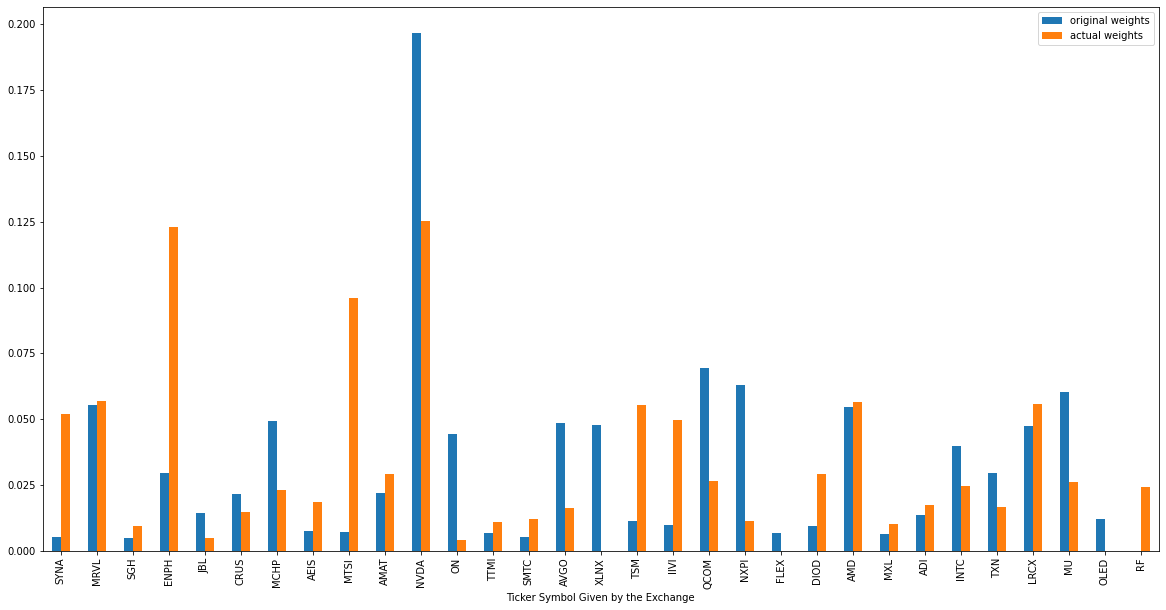

In [43]:
import matplotlib.pyplot as plt
_ = comparison_table.loc[:,["original weights","actual weights"]].plot(kind='bar', figsize=(20,10))

# Q4 VaR and ES


In [73]:
def get_historical_risk(returns_df, rolling_window_size, dates, weights, decay=0.98, risk_free_rate = 0.01):
    '''
    Function to obtain the historical risk given the dates provided. Assumes 5% VaR and 5% ES.
    
    Parameters:
    - returns_df (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - rolling_window_size (int): Integer ditating the size of the rolling window to consider when calculating the historical risk.
    - dates (list-like): Integer or list-like object containing the dates to calculate historical VaR for.
    - weights (pd.Series): Pandas series object containing the weights of each investment. Index is the ticker names for each investment.
    
    Returns:
    - risk_df (pd.DataFrame): Dataframe of the log VaR and ES of each provided date. Dates are the index.
    '''
    
    if isinstance(dates, dict):
        if ('start_date' or 'end_date') not in dates.keys():
            raise ValueError("Missing start_date or end_date variable.")
        start_date = dates['start_date']
        end_date = dates['end_date']
        dates = returns_df[(returns_df.index>=start_date)&(returns_df.index<=end_date)].index.values
    
    elif not isinstance(dates, list):
        dates = [dates,]
    
    not_found = [date for date in dates if date not in returns_df.index]
    if any(not_found):
        raise ValueError(f"{not_found} not found in provided data")
        
    returns_df.loc[:,'RF'] = (1+risk_free_rate)**(1/252) -1
        
    historical_returns = np.log((returns_df*weights).sum(axis=1)+1) # calculate the historical returns of the portfolio after weighting, then log it
    historical_var = np.zeros(len(dates)) # create empty array for fast data read/write
    historical_ES = np.zeros(len(dates)) # create empty array for fast data read/write
    
    for day_index in range(len(dates)): # for each date
        date = dates[day_index]
        rolling_window = historical_returns[historical_returns.index<date].iloc[-rolling_window_size:]
        historical_var[day_index] = np.percentile(rolling_window,5) # get 5% percentile for VaR
        sum_of_loss_returns = np.sum(rolling_window.iloc[np.where(rolling_window < historical_var[day_index])]) # formula for ES, select all values lower than the 5% VaR and sum them.\n",
        historical_ES[day_index] = sum_of_loss_returns/(rolling_window_size*0.05) # formula for ES
        risk_df = pd.DataFrame([historical_var,historical_ES],index=['5% VaR', '5% ES'],columns=dates).T
    
    return risk_df
        

In [74]:
# NOTE: LOG

def get_parametric_risk(returns_df, rolling_window_size, dates, weights, risk_free_rate = 0.01):
    '''
    Function to obtain the parametric risk given the dates provided. Assumes 5% VaR and 5% ES, and normal distribution.
    Variance is calculated as 
    
    Parameters:
    - returns_df (pd.DataFrame): Dataframe of the daily percentage returns. Tickers in the columns, and dates in the index. 
    - rolling_window_size (int): Integer ditating the size of the rolling window to consider when calculating the historical risk.
    - dates (list-like): Integer or list-like object containing the dates to calculate historical VaR for.
    - weights (pd.Series): Pandas series object containing the weights of each investment. Index is the ticker names for each investment.
    
    Returns:
    - risk_df (pd.DataFrame): Dataframe of the log VaR and ES of each provided date. Dates are the index.
    '''
    
    if isinstance(dates, dict):
        if ('start_date' or 'end_date') not in dates.keys():
            raise ValueError("Missing start_date or end_date variable.")
        start_date = dates['start_date']
        end_date = dates['end_date']
        dates = returns_df[(returns_df.index>=start_date)&(returns_df.index<=end_date)].index.values
    
    elif not isinstance(dates, list):
        dates = [dates,]
    
    not_found = [date for date in dates if date not in returns_df.index]
    if any(not_found):
        raise ValueError(f"{not_found} not found in provided data")
        
    returns_df.loc[:,'RF'] = (1+risk_free_rate)**(1/252) -1
        
    parametric_var = np.zeros(len(dates)) # create empty array for fast data read/write
    parametric_ES = np.zeros(len(dates)) # create empty array for fast data read/write
    
    for day_index in range(len(dates)): # for each date
        date = dates[day_index]
        
        individual_window = returns_df[returns_df.index<date].iloc[-rolling_window_size:] # collect the values for the logreturns for each individual stock, inclusive of the day itself
        
        # calculate mean
        mu = expected_returns.mean_historical_return(individual_window, returns_data=True) # this gives annual returns
        mu = (mu+1)**(1/252)-1 # convert to daily results
        log_mean_return = np.log((mu.values*weights).sum() +1) # in log
        
        # calculate variance 
        S = np.log(risk_models.sample_cov(individual_window, returns_data=True)/252+1) # get shrinkage covariance matrix, divide by 252 to get daily values, then log it
        
        variance_return = np.dot(weights, np.dot(S, weights)) # calculate portfolio variance

        # calculate VaR and ES
        volatility = variance_return**0.5
        z_alpha = norm.ppf(0.05)
        parametric_var[day_index] = log_mean_return + volatility*z_alpha
        parametric_ES[day_index] = log_mean_return-volatility*(norm.pdf(norm.ppf(0.05))/0.05)
    
    parametric_var = np.exp(parametric_var)-1
    parametric_ES = np.exp(parametric_ES)-1
    risk_df = pd.DataFrame([parametric_var,parametric_ES],index=['5% VaR', '5% ES'],columns=dates).T
    
    return risk_df

In [75]:
# choose dates (dict for range, or list-like for specific dates)
dates = {"start_date":"2020-12-31","end_date":"2021-6-30"}

### Risk for new portfolio

In [89]:
new_table = pd.DataFrame()
historical_risk_values = get_historical_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=comparison_table['actual weights'])
new_table['var historical'] = historical_risk_values['5% VaR']
new_table['es historical'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=comparison_table['actual weights'])
new_table['var parametric'] = parametric_risk_values['5% VaR']
new_table['es parametric'] = parametric_risk_values['5% ES']

### Risk for original portfolio

In [90]:
original_table = pd.DataFrame()
historical_risk_values = get_historical_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=comparison_table['original weights'])
original_table['var historical'] = historical_risk_values['5% VaR']
original_table['es historical'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=comparison_table['original weights'])
original_table['var parametric'] = parametric_risk_values['5% VaR']
original_table['es parametric'] = parametric_risk_values['5% ES']

### Risk for old portfolio

In [91]:
# load stocks into a dictionary
bad_fund = {}
do_not_append = [] 
for file_name in os.listdir('worst_data/'):
  ticker = file_name.split(".")[0]
  if ticker in do_not_append:
    pass
  else:
    bad_fund[f'{ticker}'] = pd.read_csv(f'worst_data/{file_name}') # for each stock, add its ticker as the key and dataframe as the value

In [92]:
print(list(bad_fund.keys())) # print the stock tickers for easy referencing

['AAPL', 'ABBV', 'ADBE', 'ADP', 'ADSK', 'AMZN', 'ANTM', 'BAH', 'EBIX', 'EEFT', 'ENS', 'EPAM', 'EXTR', 'G', 'GOOG', 'GPN', 'IIVI', 'IQV', 'JBL', 'MA', 'MSFT', 'NXPI', 'PRFT', 'QRVO', 'ROG', 'ST', 'SWKS', 'TEL', 'THR', 'UNH', 'V']


In [93]:
# Change date column into a datetime object
# Add a new column for log returns
for ticker, df in bad_fund.items():
  df['Date'] = df['Date'].apply(pd.to_datetime)
  df['LogReturns'] = np.append(np.nan,np.diff(np.log(df['Adj Close']))) # Fill dataframe with the log returns. The first value will be nan because there is no log returns for it.

In [94]:
# preview a stock
bad_fund['AAPL'].head()

,Date,Open,High,Low,Close,Adj Close,Volume,LogReturns
0,2016-10-04,28.264999,28.577499,28.157499,28.250000,26.493998,118947200,NaN
1,2016-10-05,28.350000,28.415001,28.172501,28.262501,26.505718,85812400,0.000442
2,2016-10-06,28.424999,28.584999,28.282499,28.472500,26.702660,115117200,0.007403
3,2016-10-07,28.577499,28.639999,28.377501,28.514999,26.742519,97433600,0.001492
4,2016-10-10,28.754999,29.187500,28.680000,29.012501,27.209097,144944000,0.017297


In [95]:
bad_fund_log_returns = pd.DataFrame(data=np.full((bad_fund['AAPL'].shape[0],31),np.nan), columns = sorted(list(bad_fund.keys())), index = bad_fund['AAPL'].Date) # create empty dataframe filled with NaNs, with index = Date and columns = stocks

# copy the log returns
for ticker, df in bad_fund.items():
  bad_fund_log_returns[ticker] = bad_fund_log_returns.index.map(bad_fund[ticker].set_index('Date')['LogReturns'])

# if simple returns are needed
bad_fund_simple_returns = np.exp(bad_fund_log_returns)-1
# set bad fund earliest date to the same as the good fund
bad_fund_simple_returns = bad_fund_simple_returns[bad_fund_simple_returns.index>=simple_returns.index[0]]

In [96]:
# get bad portfolio weights
bad_portfolio = pd.read_csv('original_weights_worst.csv')
bad_portfolio.index = bad_portfolio['Ticker Symbol Given by the Exchange']
del bad_portfolio['Ticker Symbol Given by the Exchange']
bad_portfolio['Security\'s Percentage of the Total Net Assets'] = bad_portfolio['Security\'s Percentage of the Total Net Assets']/100 

In [97]:
bad_table = pd.DataFrame()
historical_risk_values = get_historical_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_portfolio['Security\'s Percentage of the Total Net Assets'])
bad_table['var historical'] = historical_risk_values['5% VaR']
bad_table['es historical'] = historical_risk_values['5% ES']
parametric_risk_values = get_parametric_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_portfolio['Security\'s Percentage of the Total Net Assets'])
bad_table['var parametric'] = parametric_risk_values['5% VaR']
bad_table['es parametric'] = parametric_risk_values['5% ES']

## Plot VaR and ES comparisons

The chosen bad portfolio has a much better VaR and ES. This can be explained by it having a lower variance compared to our portfolio.

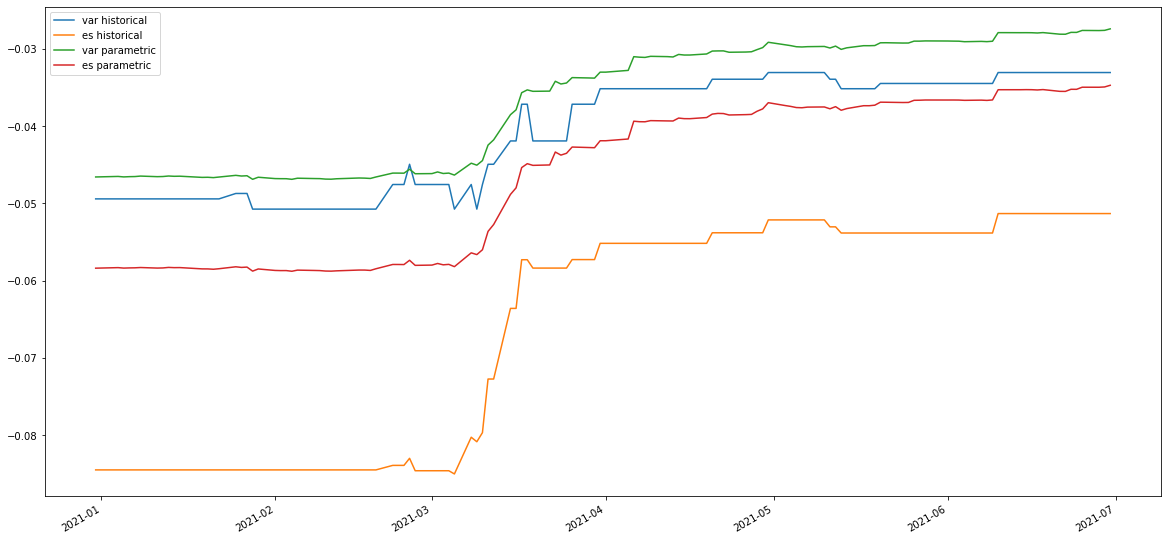

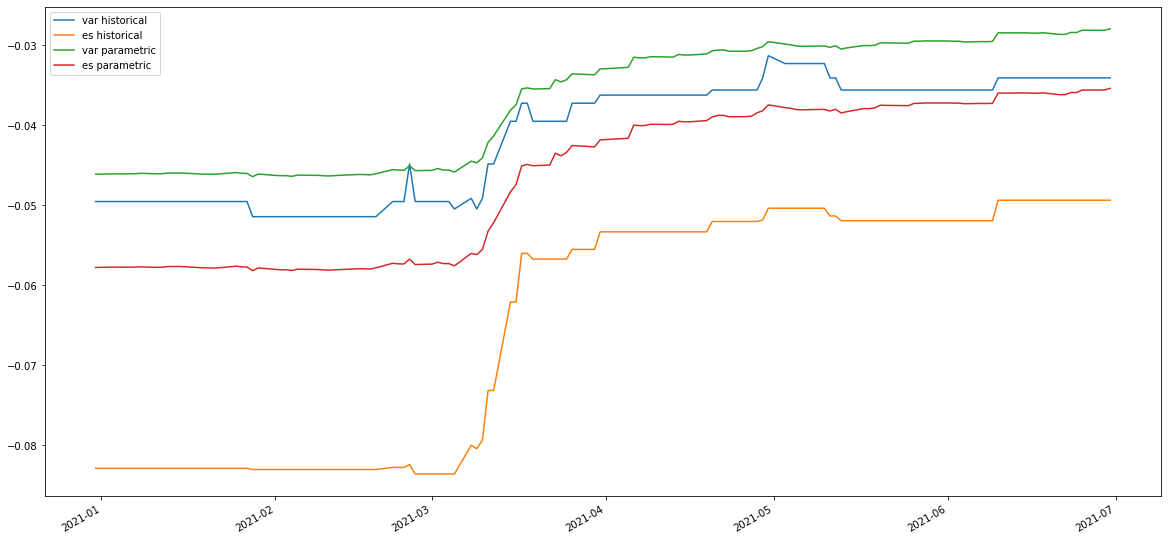

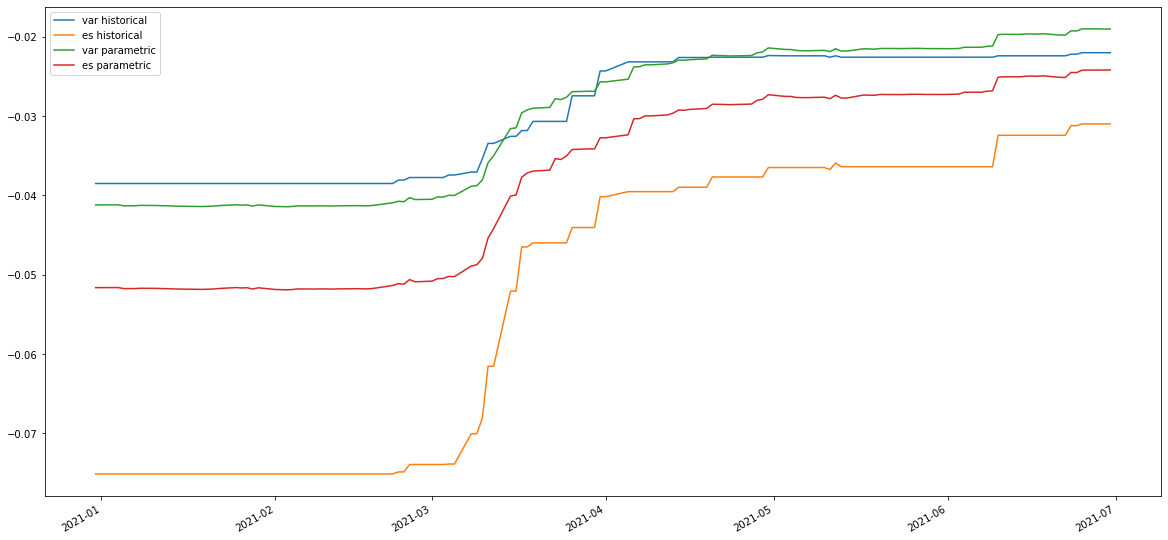

In [99]:
_ = new_table.plot(figsize=(20,10))
_ = original_table.plot(figsize=(20,10))
_ = bad_table.plot(figsize=(20,10))

# Q5 Backtesting

## Helper functions

In [62]:
backtest_start = '2021-01-01'
backtest_end = '2021-06-30'

# Get portfolio value
def portfolio_returns(returns_df, weights, start, end):
    # Get only the period we want
    testing_period_mask = (returns_df.index<=end) & (returns_df.index >= start)
    testing_period_df = returns_df[testing_period_mask]
    
    # Calculate historical log returns of the portfolio
    historical_returns = np.log((testing_period_df*weights).sum(axis=1)+1)
    
    # Put it in a dataframe
    historical_returns = pd.DataFrame(historical_returns, columns=['log_returns'])
    historical_returns['next_day_log_returns'] = historical_returns['log_returns'].shift(-1)
    return historical_returns

def run_backtesting(returns, parametric_risk, historical_risk, backtesting_alpha=0.01):
    # parametric 95% VaR 
    returns_95_VaR_par = returns.copy()
    returns_95_VaR_par['risk'] = parametric_risk['5% VaR']
    
    # parametric 95% ES
    returns_95_ES_par = returns.copy()
    returns_95_ES_par['risk'] = parametric_risk['5% ES']
    
    # historical 95% VaR 
    returns_95_VaR_hist = returns.copy()
    returns_95_VaR_hist['risk'] = historical_risk['5% VaR']
    
    # historical 95% ES
    returns_95_ES_hist = returns.copy()
    returns_95_ES_hist['risk'] = historical_risk['5% ES']
    
    backtest_order = (returns_95_VaR_par, returns_95_ES_par, returns_95_VaR_hist, returns_95_ES_hist)
    backtest_type = ('Parametric 95% VaR', 'Parametric 95% ES', 'Historical 95% VaR', 'Historical 95% ES')
    
    for test,df in zip(backtest_type, backtest_order):
        # Carry out backtesting
        observed_level = 1-len(df[df['risk'] > df['next_day_log_returns']])/len(df)
        observations = len(df)
        failures = len(df[df['risk'] > df['next_day_log_returns']])
        expected = observations * 0.05
        ratio = failures/expected
        p_value_95 = 1-binom.cdf(failures,observations,0.05)
        
        print(test)
        print(f"\tObservations: {observations}")
        print(f"\tFailures: {failures}")
        print(f"\tExpected: {expected}")
        print(f"\tRatio: {ratio:.2f}")
        print(f"\tp-value of {test}: {p_value_95}")
        if (p_value_95 < backtesting_alpha):
            print("\tReject null hypothesis under binomial distribution")
        else:
            print(f"\tNot enough evidence to reject null hypothesis at {backtesting_alpha} backtesting significance level under binomial distribution")
        print()    
    return

## Bad fund

In [63]:
bad_fund_weights = bad_portfolio['Security\'s Percentage of the Total Net Assets']

bad_funds_backtest = portfolio_returns(bad_fund_simple_returns,bad_fund_weights, backtest_start, backtest_end)
bad_funds_parametric_risk = get_parametric_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_fund_weights)
bad_funds_historical_risk = get_historical_risk(returns_df=bad_fund_simple_returns, rolling_window_size=250, dates=dates, weights=bad_fund_weights)

In [64]:
run_backtesting(bad_funds_backtest, bad_funds_parametric_risk, bad_funds_historical_risk, backtesting_alpha=0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 3
	Expected: 6.2
	Ratio: 0.48
	p-value of Parametric 95% VaR: 0.8723071485270615
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Parametric 95% ES
	Observations: 124
	Failures: 1
	Expected: 6.2
	Ratio: 0.16
	p-value of Parametric 95% ES: 0.9869890354874802
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 57
	Expected: 6.2
	Ratio: 9.19
	p-value of Historical 95% VaR: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution

Historical 95% ES
	Observations: 124
	Failures: 57
	Expected: 6.2
	Ratio: 9.19
	p-value of Historical 95% ES: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution



## Original(Best) Fund

In [65]:
orig_funds_weights = comparison_table['original weights']

orig_funds_backtest = portfolio_returns(simple_returns, orig_funds_weights, backtest_start, backtest_end)
orig_funds_parametric_risk = get_parametric_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=orig_funds_weights)
orig_funds_historical_risk = get_historical_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=orig_funds_weights)

In [66]:
run_backtesting(orig_funds_backtest, orig_funds_parametric_risk, orig_funds_historical_risk, backtesting_alpha = 0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 8
	Expected: 6.2
	Ratio: 1.29
	p-value of Parametric 95% VaR: 0.1689451076373536
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Parametric 95% ES
	Observations: 124
	Failures: 4
	Expected: 6.2
	Ratio: 0.65
	p-value of Parametric 95% ES: 0.7478633073546315
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 54
	Expected: 6.2
	Ratio: 8.71
	p-value of Historical 95% VaR: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution

Historical 95% ES
	Observations: 124
	Failures: 54
	Expected: 6.2
	Ratio: 8.71
	p-value of Historical 95% ES: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution



## Optimized Fund

In [67]:
opt_funds_weights = comparison_table['actual weights']

opt_funds_backtest = portfolio_returns(simple_returns, opt_funds_weights, backtest_start, backtest_end)
opt_funds_parametric_risk = get_parametric_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=opt_funds_weights)
opt_funds_historical_risk = get_historical_risk(returns_df=simple_returns, rolling_window_size=250, dates=dates, weights=opt_funds_weights)

In [68]:
run_backtesting(opt_funds_backtest, opt_funds_parametric_risk, opt_funds_historical_risk, backtesting_alpha = 0.05)

Parametric 95% VaR
	Observations: 124
	Failures: 8
	Expected: 6.2
	Ratio: 1.29
	p-value of Parametric 95% VaR: 0.1689451076373536
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Parametric 95% ES
	Observations: 124
	Failures: 4
	Expected: 6.2
	Ratio: 0.65
	p-value of Parametric 95% ES: 0.7478633073546315
	Not enough evidence to reject null hypothesis at 0.05 backtesting significance level under binomial distribution

Historical 95% VaR
	Observations: 124
	Failures: 57
	Expected: 6.2
	Ratio: 9.19
	p-value of Historical 95% VaR: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution

Historical 95% ES
	Observations: 124
	Failures: 57
	Expected: 6.2
	Ratio: 9.19
	p-value of Historical 95% ES: 1.1102230246251565e-16
	Reject null hypothesis under binomial distribution

